LILA FIFA ARDANI 24083010025

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import statsmodels.stats.diagnostic as dg
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan

# **LOAD DATASET**

In [8]:
df_train = pd.read_csv('train_dataset.csv')
df_test = pd.read_csv('test_dataset_no_y.csv')
df_train.head(5)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.407166,E,W,2.0,M,C,1.127628,-0.657689,-0.415323,76.124758,20.710704
1,44.417166,M,W,1.0,H,C,0.957628,-0.667689,-0.475323,85.834758,94.202404
2,28.047166,M,W,4.0,L,R,0.717628,-1.107689,-0.385323,13.814758,43.043004
3,-0.462834,NaN,W,2.0,L,C,1.717628,-1.547689,-0.425323,29.344758,7.956004
4,42.957166,M,W,3.0,M,C,0.747628,-1.847689,-0.135323,NaN,62.397804


In [9]:
df_test.head(5)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,16.787166,N,W,2.0,L,C,2.807628,-0.687689,-0.175323,103.314758
1,38.137166,M,NaN,1.0,M,C,2.197628,-0.617689,-0.195323,14.644758
2,20.797166,E,W,1.0,M,S,3.007628,-0.687689,-0.235323,41.574758
3,15.577166,A,W,4.0,M,C,0.707628,-0.827689,-0.125323,107.614758
4,44.677166,M,W,4.0,L,C,3.027628,-0.447689,-0.345323,92.434758


# **MENANGANI MISSING VALUE & OUTLIER**

In [12]:
#MISSING VALUE
df_train = df_train.dropna(subset=['y']).reset_index(drop=True)

num_cols = ['x1', 'x7', 'x8', 'x9', 'x10']
for col in num_cols:
    med = df_train[col].median()
    df_train[col] = df_train[col].fillna(med)
    df_test[col] = df_test[col].fillna(med)
    print(f"Kolom {col}: Mengisi missing value dengan median = {med:.2f}")
    print(f"Jumlah missing value setelah pengisian: {df_train[col].isnull().sum()}")

#OUTLIER
before_outlier = df_train.shape[0]

Q1 = df_train['y'].quantile(0.25)
Q3 = df_train['y'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df_train = df_train[(df_train['y'] >= lower) & (df_train['y'] <= upper)]

after_outlier = df_train.shape[0]

print(f"Batas Bawah (Lower Bound): {lower:.2f}")
print(f"Batas Atas (Upper Bound): {upper:.2f}")
print(f"Jumlah outlier yang dihapus: {before_outlier - after_outlier}")
print(f"Ukuran dataset sekarang: {df_train.shape}")

Kolom x1: Mengisi missing value dengan median = 23.43
Jumlah missing value setelah pengisian: 0
Kolom x7: Mengisi missing value dengan median = 1.76
Jumlah missing value setelah pengisian: 0
Kolom x8: Mengisi missing value dengan median = -1.21
Jumlah missing value setelah pengisian: 0
Kolom x9: Mengisi missing value dengan median = -0.33
Jumlah missing value setelah pengisian: 0
Kolom x10: Mengisi missing value dengan median = 59.04
Jumlah missing value setelah pengisian: 0
Batas Bawah (Lower Bound): -18.90
Batas Atas (Upper Bound): 110.74
Jumlah outlier yang dihapus: 1
Ukuran dataset sekarang: (731, 11)


# **ENCODING KATEGORI**

In [13]:
cat_cols = ['x2', 'x6']
df_train_proc = pd.get_dummies(df_train, columns=cat_cols, drop_first=True, dtype=int)
df_test_proc = pd.get_dummies(df_test, columns=cat_cols, drop_first=True, dtype=int)

print(f"Fitur kategori yang diproses: {cat_cols}")
print(f"Jumlah kolom setelah encoding: {df_train_proc.shape[1]}")
print(f"Contoh kolom dummy baru: {[c for c in df_train_proc.columns if 'x2_' in c or 'x6_' in c][:5]}")

Fitur kategori yang diproses: ['x2', 'x6']
Jumlah kolom setelah encoding: 14
Contoh kolom dummy baru: ['x2_E', 'x2_M', 'x2_N', 'x6_R', 'x6_S']


# **FEATURE ENGINEERING**

In [14]:
df_train_proc['x1_x8'] = df_train_proc['x1'] * df_train_proc['x8']
df_test_proc['x1_x8'] = df_test_proc['x1'] * df_test_proc['x8']

print("Fitur interaksi 'x1_x8' berhasil dibuat.")

Fitur interaksi 'x1_x8' berhasil dibuat.


In [15]:
features = ['x1', 'x8', 'x9', 'x10', 'x1_x8'] + [c for c in df_train_proc.columns if 'x2_' in c or 'x6_' in c]

X = df_train_proc[features]
y = df_train_proc['y']
X = sm.add_constant(X)

# **MEMBANGUN MODEL**

In [17]:
model_initial = sm.OLS(y, X).fit()
significant_vars = model_initial.pvalues[model_initial.pvalues < 0.05].index.tolist()

X_final = X[significant_vars]
final_model = sm.OLS(y, X_final).fit()

print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     1668.
Date:                Mon, 29 Dec 2025   Prob (F-statistic):               0.00
Time:                        12:47:13   Log-Likelihood:                -2400.4
No. Observations:                 731   AIC:                             4813.
Df Residuals:                     725   BIC:                             4840.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.6781      1.542     16.649      0.0

# **MENYIMPAN HASIL PREDICTION**

In [21]:
df_test_final = df_test_proc.reindex(columns=X_final.columns, fill_value=0)
if 'const' in X_final.columns:
    df_test_final['const'] = 1.0

y_pred = final_model.predict(df_test_final)
print(y_pred)

# Simpan Hasil
submission = pd.DataFrame({
    'Id': range(len(y_pred)),
    'y': y_pred
})
submission.to_csv('submission_min_rmse.csv', index=False)

0       73.078565
1       84.055669
2       57.706820
3       72.845623
4      117.812854
          ...    
188     97.070532
189     21.364185
190      6.101392
191     25.562161
192     45.598098
Length: 193, dtype: float64


# **CEK MSE**

In [22]:
mse_train = final_model.mse_resid

print(f"MSE Training  : {mse_train:.4f}")


MSE Training  : 42.0020


# **RESIDUAL**

In [23]:
# Prediksi & residual
y_pred_train = final_model.predict(X_final)
residual = y - y_pred_train


In [24]:
print("Statistik Residual:")
residual.describe()


Statistik Residual:


,0
count,7.310000e+02
mean,-2.785794e-14
std,6.458659e+00
min,-3.850242e+01
25%,-2.323994e+00
50%,1.770865e-01
75%,2.570648e+00
max,3.375449e+01


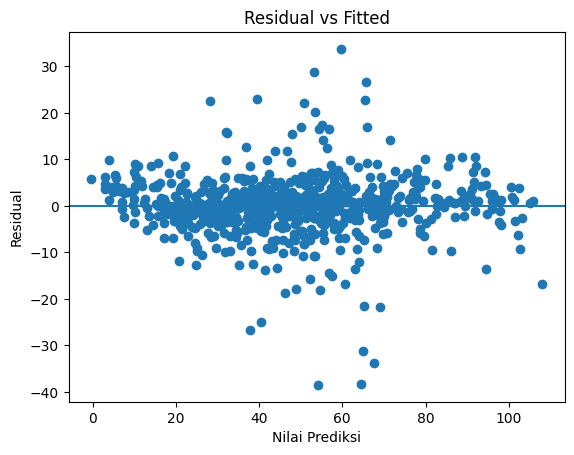

In [25]:
plt.figure()
plt.scatter(y_pred_train, residual)
plt.axhline(0)
plt.xlabel("Nilai Prediksi")
plt.ylabel("Residual")
plt.title("Residual vs Fitted")
plt.show()


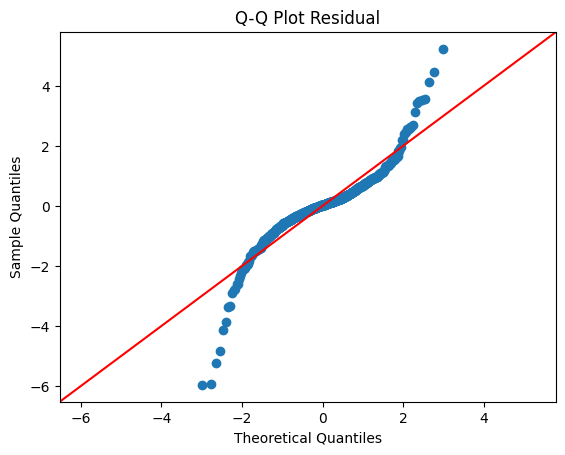

In [37]:
sm.qqplot(residual, line='45',fit=True)
plt.title("Q-Q Plot Residual")
plt.show()


# **LINIEARITAS**

In [41]:
stat, p_value = dg.linear_rainbow(final_model)
print(f"Rainbow Test p-value: {p_value:.4f}")

if p_value > 0.05:
    print("Kesimpulan: Model secara signifikan bersifat LINEAR.")
else:
    print("Kesimpulan: Model terindikasi TIDAK LINEAR.")

Rainbow Test p-value: 0.3020
Kesimpulan: Model secara signifikan bersifat LINEAR.


# **NORMALITAS**

In [32]:
stat, p_shapiro = shapiro(residual)

print("Uji Normalitas (Shapiro-Wilk)")
print(f"p-value = {p_shapiro:.4f}")

if p_shapiro > 0.05:
    print("Kesimpulan: Asumsi normalitas residual TERPENUHI.\n")
else:
    print("Kesimpulan: Asumsi normalitas residual TIDAK TERPENUHI.\n")

Uji Normalitas (Shapiro-Wilk)
p-value = 0.0000
Kesimpulan: Asumsi normalitas residual TIDAK TERPENUHI.



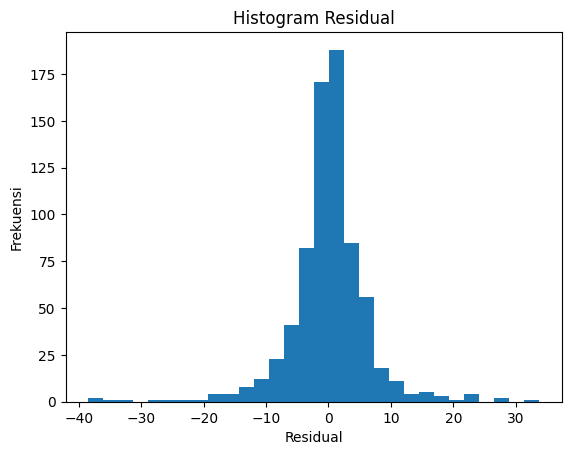

In [26]:
plt.figure()
plt.hist(residual, bins=30)
plt.xlabel("Residual")
plt.ylabel("Frekuensi")
plt.title("Histogram Residual")
plt.show()


# **HETEROSKEDASTISITAS**

In [34]:
bp_test = het_breuschpagan(residual, X_final)
lm_pvalue = bp_test[1]
f_pvalue = bp_test[3]

print("Uji Heteroskedastisitas (Breusch-Pagan)")
print(f"LM p-value = {lm_pvalue:.4f}")
print(f"F  p-value = {f_pvalue:.4f}")

if lm_pvalue > 0.05 and f_pvalue > 0.05:
    print("Kesimpulan: Tidak terdapat heteroskedastisitas (asumsi homoskedastisitas TERPENUHI).")
else:
    print("Kesimpulan: Terdapat heteroskedastisitas (asumsi homoskedastisitas TIDAK TERPENUHI).")

Uji Heteroskedastisitas (Breusch-Pagan)
LM p-value = 0.4384
F  p-value = 0.4401
Kesimpulan: Tidak terdapat heteroskedastisitas (asumsi homoskedastisitas TERPENUHI).


# **AUTOKORELASI**

In [35]:
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(residual)

print("Uji Autokorelasi (Durbin-Watson)")
print(f"Nilai DW = {dw:.4f}")

if 1.5 <= dw <= 2.5:
    print("Kesimpulan: Tidak terdapat autokorelasi.\n")
else:
    print("Kesimpulan: Terdapat autokorelasi.\n")


Uji Autokorelasi (Durbin-Watson)
Nilai DW = 2.0449
Kesimpulan: Tidak terdapat autokorelasi.



# **COOK'S**

In [39]:
influence = final_model.get_influence()
cooks_d = influence.cooks_distance[0]
influential = np.sum(cooks_d > 1)

print(f"Jumlah observasi berpengaruh (Cook's D > 1): {influential}")


Jumlah observasi berpengaruh (Cook's D > 1): 0


# **MULTIKOLINIERITAS**

In [67]:
features = ['x1', 'x8', 'x9', 'x10', 'x1_x8']
X_vif = df_train_proc[features].copy()
X_vif = sm.add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["Fitur"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
vif_tampil = vif_data[vif_data["Fitur"] != 'const'].sort_values(by="VIF", ascending=False)

print("--- HASIL UJI MULTIKOLINEARITAS (VIF) ---")
print(vif_tampil.to_string(index=False))

--- HASIL UJI MULTIKOLINEARITAS (VIF) ---
Fitur       VIF
x1_x8 12.521131
   x1  9.139531
   x8  3.474999
  x10  1.019077
   x9  1.005730


# **MENGATASI MULTIKOL DENGAN MEAN CENTERING**

In [65]:
mean_x1 = df_train_proc['x1'].mean()
mean_x8 = df_train_proc['x8'].mean()

df_train_proc['x1_centered'] = df_train_proc['x1'] - mean_x1
df_train_proc['x8_centered'] = df_train_proc['x8'] - mean_x8

df_train_proc['x1_x8_centered'] = df_train_proc['x1_centered'] * df_train_proc['x8_centered']

features_centered = ['x1_centered', 'x8_centered', 'x9', 'x10', 'x1_x8_centered']
X_new = df_train_proc[features_centered]
X_new = sm.add_constant(X_new)

# VIF Baru
vif_new = pd.DataFrame()
vif_new["Fitur"] = X_new.columns
vif_new["VIF"] = [variance_inflation_factor(X_new.values, i) for i in range(len(X_new.columns))]
vif_tampil = vif_new[vif_new["Fitur"] != 'const']

print("--- VIF SETELAH MEAN CENTERING ---")
print(vif_tampil.to_string(index=False))

--- VIF SETELAH MEAN CENTERING ---
         Fitur      VIF
   x1_centered 1.014745
   x8_centered 1.014030
            x9 1.005730
           x10 1.019077
x1_x8_centered 1.020460


# **MODEL DENGAN HC3**

In [45]:
model_hc3 = final_model.get_robustcov_results(cov_type='HC3')

print("--- RINGKASAN MODEL (ROBUST HC3) ---")
print(model_hc3.summary())

--- RINGKASAN MODEL (ROBUST HC3) ---
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     2323.
Date:                Mon, 29 Dec 2025   Prob (F-statistic):               0.00
Time:                        13:14:38   Log-Likelihood:                -2400.4
No. Observations:                 731   AIC:                             4813.
Df Residuals:                     725   BIC:                             4840.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         2

# **UJI F**

In [47]:
print(f"F-statistic: {model_hc3.fvalue:.4f}")
print(f"Prob (F-statistic): {model_hc3.f_pvalue:.4f}")

if model_hc3.f_pvalue < 0.05:
    print("Kesimpulan: Signifikan secara simultan (Minimal ada satu fitur yang berpengaruh).")
else:
    print("Kesimpulan: Tidak signifikan secara simultan.")

F-statistic: 2323.3951
Prob (F-statistic): 0.0000
Kesimpulan: Signifikan secara simultan (Minimal ada satu fitur yang berpengaruh).


# **UJI T**

In [53]:
feature_names = X.columns
p_values = model_hc3.pvalues

for name, p_val in zip(feature_names, p_values):
    status = "SIGNIFIKAN" if p_val < 0.05 else "TIDAK SIGNIFIKAN"
    print(f"Fitur {name:20}: p-value = {p_val:.4f} ({status})")

Fitur const               : p-value = 0.0000 (SIGNIFIKAN)
Fitur x1                  : p-value = 0.0000 (SIGNIFIKAN)
Fitur x8                  : p-value = 0.0005 (SIGNIFIKAN)
Fitur x9                  : p-value = 0.0000 (SIGNIFIKAN)
Fitur x10                 : p-value = 0.0000 (SIGNIFIKAN)
Fitur x1_x8               : p-value = 0.0000 (SIGNIFIKAN)
